# Calibration of climate parameters

In [1]:
# Change directory if the current is 'notebook'
%cd ..

c:\Users\tsutsui\Projects\mce


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from mce.core.climate_parms import ParmEstimate

In [3]:
def calib_climate(time, data, data_std, nl=3):
    if nl == 3:
        # ([a1/a0, a2/a0], [tau0, tau1/tau0, tau2/tau1])
        args = ([1., 1.], [1., 10., 20.])
    elif nl == 2:
        # ([a1/a0], [tau0, tau1/tau0])
        args = ([1.], [2., 100.])

    kw = {'lamb': 1., 'ts4xeq': 7., 'beta': 1.}

    obj = ParmEstimate(nl=nl)
    px = obj.initpars(*args, **kw)
    alpha, beta, lamb, asj, tauj = obj.minimize_wrap(time, data, data_std)

    ecs = obj.forcing.x2erf(2.) / lamb
    t70 = np.log(2.) / np.log(1.01)
    tcr = ecs * (1 - (asj * tauj * (1 - np.exp(-t70/tauj))).sum() / t70)

    regress = linregress(data[1], data[0])
    lambda_reg = -regress.slope
    ecs_reg = 0.5 * regress.intercept / lambda_reg
    tcr_gcm = data[3][70-10:70+10].mean()

    return pd.Series({
        'ecs': ecs,
        'ecs_reg': ecs_reg,
        'tcr': tcr,
        'tcr_gcm': tcr_gcm,
        'co2_alpha': alpha,
        'co2_beta': beta,
        'lambda': lamb,
        'lambda_reg': lambda_reg,
        **{
            f'tau{i}': value
            for i, value in enumerate(tauj)
        },
        **{
            f'a{i}': value
            for i, value in enumerate(asj)
        },
    })

In [4]:
# Read normalized CMIP5 and CMIP6 data
with pd.HDFStore('data/cmip_normalized.h5', 'r') as store:
    df_norm_cmip5 = store['CMIP5/climate_norm1']
    df_norm_cmip6 = store['CMIP6/climate_norm1']

## Calibration to CMIP5 models

In [5]:
df_parms = {}

for source_id, df in df_norm_cmip5.groupby(level=0):
    if df.shape[0] != 6:
        continue

    df = df.droplevel(0)
    data = [
        df.loc[('rtnt', 'abrupt4xCO2')].dropna().values,
        df.loc[('tas', 'abrupt4xCO2')].dropna().values,
        df.loc[('rtnt', '1pctCO2')].dropna().values,
        df.loc[('tas', '1pctCO2')].dropna().values,
    ]
    if [len(d1) for d1 in data] != [150, 150, 140, 140]:
        raise ValueError('Invalid data length')

    time = np.arange(150) + 0.5

    data_std = [
        df.loc[('rtnt', 'piControl')].dropna().std(ddof=0),
        df.loc[('tas', 'piControl')].dropna().std(ddof=0),
    ]

    df_parms[source_id] = calib_climate(time, data, data_std, nl=3)

df_parms_cmip5 = pd.DataFrame(df_parms).T.sort_index(key=lambda x: x.str.lower())

In [6]:
df_parms_cmip5

,ecs,ecs_reg,tcr,tcr_gcm,co2_alpha,co2_beta,lambda,lambda_reg,tau0,tau1,tau2,a0,a1,a2
ACCESS1.0,3.750823,3.827931,1.982799,1.921747,4.246654,1.019410,0.784776,0.777060,1.771025,11.862830,219.728920,0.309701,0.186391,0.503909
ACCESS1.3,3.261569,3.531926,1.697960,1.631630,3.925020,1.075596,0.834143,0.819500,1.084692,7.637977,255.383861,0.183191,0.311308,0.505501
BCC-CSM1.1,2.729099,2.826381,1.798378,1.736432,4.450616,1.037867,1.130385,1.137433,1.677255,9.770735,141.682897,0.349640,0.278756,0.371604
BNU-ESM,3.896530,3.923890,2.445166,2.490674,5.453729,1.007902,0.970155,0.966931,1.255106,9.066619,291.727752,0.288967,0.349246,0.361787
CanESM2,3.642716,3.691430,2.298460,2.340212,5.352105,1.018086,1.018415,1.038722,2.171617,21.438134,261.580546,0.447794,0.222856,0.329350
CCSM4,2.866472,2.956765,1.789678,1.769586,4.917046,1.040323,1.189000,1.227101,0.207641,4.378526,170.572083,0.167795,0.406360,0.425844
CNRM-CM5,3.024565,3.250497,2.017435,2.021793,5.062562,1.073098,1.160200,1.142280,0.690588,9.719575,369.713490,0.277163,0.425619,0.297218
CSIRO-Mk3.6.0,3.535273,4.077746,1.673795,1.747981,3.293942,1.146928,0.645830,0.633373,0.954390,8.626281,204.039665,0.203006,0.209335,0.587660
FGOALS-s2,4.116452,4.153607,2.266641,2.425506,5.253778,1.015107,0.884655,0.918968,0.000757,4.661470,315.520813,0.091078,0.441011,0.467910
GFDL-CM3,3.879747,3.969521,2.013614,1.951139,4.206727,1.027046,0.751565,0.752759,2.763182,45.018009,396.691213,0.375365,0.261416,0.363219


In [62]:
df = df_parms_cmip5

asj = df[['a0', 'a1', 'a2']].values
tauj = df[['tau0', 'tau1', 'tau2']].values
lamb = df['lambda'].values

xitot = (asj*tauj).sum(axis=1) * lamb
xis = lamb / (asj/tauj).sum(axis=1)

lamb1 = (asj/(tauj*tauj)).sum(axis=1) / lamb * xis * xis - lamb
x2 = tauj.sum(axis=1) - (xitot/lamb) - (xitot-xis)/lamb1
xi1 = tauj.prod(axis=1) * lamb * lamb1 / (xis * x2)
xi2 = xitot - (xis + xi1)
lamb2 = xi2 / x2

lambk = [lamb1, lamb2]
xik = [xi1, xi2]

det = tauj[:, 2]/tauj[:, 0] - tauj[:, 1]/tauj[:, 0] \
    + tauj[:, 0]/tauj[:, 1] - tauj[:, 2]/tauj[:, 1] \
    + tauj[:, 1]/tauj[:, 2] - tauj[:, 0]/tauj[:, 2]
det2 = np.array(
    [tauj[:, 0]/tauj[:, 1] - tauj[:, 0]/tauj[:, 2],
        tauj[:, 1]/tauj[:, 2] - tauj[:, 1]/tauj[:, 0],
        tauj[:, 2]/tauj[:, 0] - tauj[:, 2]/tauj[:, 1]] )
det1 = det2 - np.array(
    [x2/tauj[:, 1] - x2/tauj[:, 2],
        x2/tauj[:, 2] - x2/tauj[:, 0],
        x2/tauj[:, 0] - x2/tauj[:, 1]] )
akj = [(det1/det).T, (det2/det).T]

# errors are negligible, but ensure accurate normalization
akj[0] = akj[0] / akj[0].sum(axis=1)[:, None]
akj[1] = akj[1] / akj[1].sum(axis=1)[:, None]


lambk = np.vstack([lamb, lambk]).T
xik = np.vstack([xis, xik]).T
akj = np.stack([asj, akj[0], akj[1]]).transpose([1, 0, 2])

In [74]:
i = 0
asj = df.iloc[i][['a0', 'a1', 'a2']].values
tauj = df.iloc[i][['tau0', 'tau1', 'tau2']].values
lamb = df.iloc[i]['lambda']

lambk_1, xik_1, akj_1 = driver.climate.get_parms_ebm(asj=asj, tauj=tauj, lamb=lamb)

In [75]:
(
    np.array_equal(lambk[i], lambk_1),
    np.array_equal(xik[i], xik_1),
    np.array_equal(akj[i], akj_1),
)

(True, True, True)

In [8]:
df_parms_cmip5.to_hdf('data/parms_calib_climate.h5', key='cmip5/norm1_l3')

## Calibration to CMIP6 models

In [6]:
df_parms = {}

for source_id, df in df_norm_cmip6.groupby(level=0):
    if df.shape[0] != 6:
        continue

    df = df.droplevel(0)
    data = [
        df.loc[('rtnt', 'abrupt-4xCO2')].dropna().values,
        df.loc[('tas', 'abrupt-4xCO2')].dropna().values,
        df.loc[('rtnt', '1pctCO2')].dropna().values,
        df.loc[('tas', '1pctCO2')].dropna().values,
    ]
    if [len(d1) for d1 in data] != [150, 150, 140, 140]:
        raise ValueError('Invalid data length')

    time = np.arange(150) + 0.5

    data_std = [
        df.loc[('rtnt', 'piControl')].dropna().std(ddof=0),
        df.loc[('tas', 'piControl')].dropna().std(ddof=0),
    ]

    df_parms[source_id] = calib_climate(time, data, data_std, nl=3)

df_parms_cmip6 = pd.DataFrame(df_parms).T.sort_index(key=lambda x: x.str.lower())

In [9]:
df_parms_cmip5.to_hdf('data/parms_calib_climate.h5', key='cmip6/norm1_l3')

## Example emulation runs

In [64]:
from mce.core.forcing import RfCO2
from mce.core.climate import IrmBase

In [65]:
class Driver:
    def __init__(self):
        self.forcing = RfCO2()
        self.climate = IrmBase()

    def parms_update(self, parms):
        self.forcing.parms.update(
            alpha=parms['co2_alpha'],
            beta=parms['co2_beta'],
        )
        self.climate.parms.update(
            asj=parms[['a0', 'a1', 'a2']].values,
            tauj=parms[['tau0', 'tau1', 'tau2']].values,
            lamb=parms['lambda'],
        )

    def run(self, time_4x, time_1p, parms):
        self.parms_update(parms)

        df_irm = {}

        # 4xCO2 forcing
        q4x = self.forcing.x2erf(4.)

        d1 = self.climate.response_ideal(
            time_4x, kind='step', variable='flux',
        )
        df_irm['abrupt-4xCO2'] = pd.DataFrame({
            'tas': (1. - d1) * q4x / parms['lambda'],
            'rtnt': d1 * q4x,
        }, index=time)

        # 1pctCO2 forcing
        q1p = self.forcing.x2erf(1.01 ** time_1p)
        d1 = self.climate.response(time_1p, q1p)
        df_irm['1pctCO2'] = pd.DataFrame({
            'rtnt': q1p - q1p / parms['lambda'],
            'tas': d1,
        }, index=time_1p)

        return pd.concat(df_irm, axis=1).T

In [66]:
driver = Driver()

In [13]:
# Time points have initial 0 and subsequent mid points
# with spacing of 1 year during the first 150 years
# and of 10 years after that until year 3000 
time = np.hstack([
    0., 
    np.arange(150) + 0.5,
    np.arange(160, 3000+1, 10) - 0.5,
])

In [15]:
source_id = 'MIROC-ES2L'
parms = df_parms_cmip6.loc[source_id]
df_irm = driver.run(time, time[:141], parms)

## Comparison between the GCM and emulator

In [64]:
import matplotlib as mpl
from mce.util.plot_base import PlotBase

In [65]:
myplt = PlotBase(palette='ipcc_wg1')

In [68]:
def mk_darker(color_hex):
    sca = np.array([1., 1., 0.7])
    return mpl.colors.to_hex(mpl.colors.hsv_to_rgb(
        mpl.colors.rgb_to_hsv(mpl.colors.to_rgb(color_hex)) * sca
    ))

colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
color_4x = colors[2]
color_1p = colors[1]
color_4x_dark = mk_darker(colors[2])
color_1p_dark = mk_darker(colors[1])

In [72]:
map_name_unit = {
    'rtnt': '{} ({})'.format('TOA net radiation', 'Wm$^{−2}$'),
    'tas': '{} ({})'.format('Temperature change', '°C'),
}

ls_gcm = {
    'ls': 'None', 'mfc': 'none', 'ms': 4, 'mew': 0.6, 'alpha': 0.8,
}
map_ls = {
    ('GCM', 'abrupt-4xCO2'): {'color': color_4x, 'marker': 's', **ls_gcm},
    ('GCM', '1pctCO2'): {'color': color_1p, 'marker': '^', **ls_gcm},
    ('IRM', 'abrupt-4xCO2'): {'color': color_4x_dark, 'lw': 1.5},
    ('IRM', '1pctCO2'): {'color': color_1p_dark, 'lw': 1.5},
    'TCR GCM': { # 20-yr mean in years 60 to 79
        'color': color_1p, 'lw': 1.5,
    },
    'TCR IRM': {
        'ls': 'None', 'mfc': 'w', 'mec': color_1p_dark, 'ms': 5,
        'mew': 1., 'marker': 'o',
    },
}

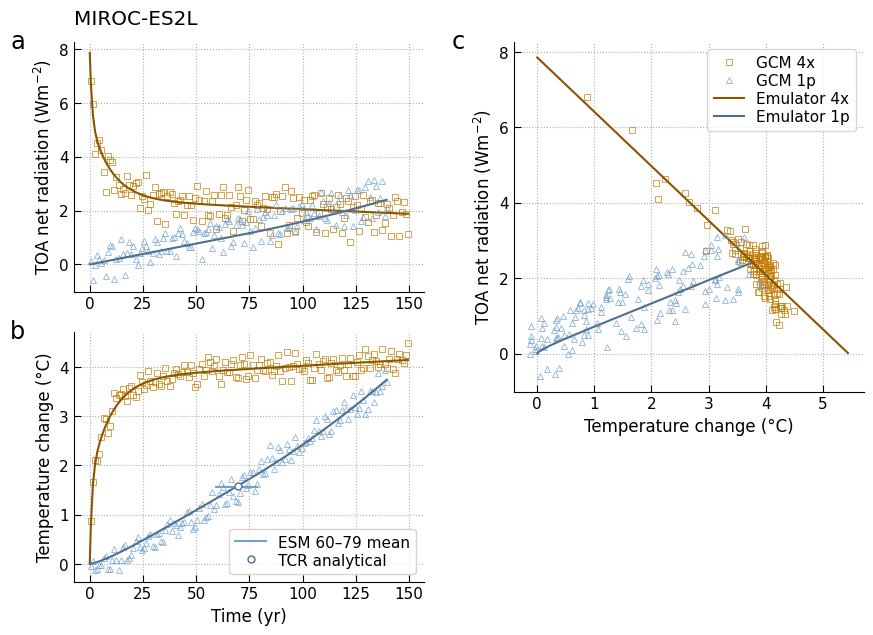

In [73]:
df_gcm = (
    df_norm_cmip6.loc[source_id]
    .reorder_levels([1, 0]).sort_index()
)

height = 2.5
aspect = 1.4
wspace = 0.9
hspace = 0.4
kw1 = {
    'height': height*aspect, 'aspect': 1.,
    'yoff': height*2 + hspace - height*aspect,
}
myplt.init_general(
    height=height, aspect=aspect, wspace=wspace, hspace=hspace,
    extend=[('bottom', -1, {}), ('right', -1, kw1)],
)

for n, variable_id in enumerate(['rtnt', 'tas']):
    ax = myplt(n)

    for experiment_id in ['abrupt-4xCO2', '1pctCO2']:
        df_gcm.loc[(experiment_id, variable_id)].dropna().plot(
            ax=ax, **map_ls[('GCM', experiment_id)],
        )
        df_irm.loc[(experiment_id, variable_id)].loc[:151].dropna().plot(
            ax=ax, **map_ls[('IRM', experiment_id)],
        )

    ax.set_ylabel(map_name_unit[variable_id])
    if n == 1:
        ax.set_xlabel('Time (yr)')

    ax.grid()

ax.hlines(parms['tcr_gcm'], 59., 79., **map_ls['TCR GCM'])
tp_2x = np.log(2) / np.log(1.01)
ax.plot(tp_2x, parms['tcr'], **map_ls['TCR IRM'])

handles = [
    mpl.lines.Line2D([0], [0], **map_ls['TCR GCM']),
    mpl.lines.Line2D([0], [0], **map_ls['TCR IRM']),
]
labels = ['ESM 60–79 mean', 'TCR analytical']
ax.legend(handles, labels, labelspacing=0.2)

ax = myplt(2)

for experiment_id in ['abrupt-4xCO2', '1pctCO2']:
    ax.plot(
        df_gcm.loc[(experiment_id, 'tas')].dropna().values,
        df_gcm.loc[(experiment_id, 'rtnt')].dropna().values,
        **map_ls[('GCM', experiment_id)],
    )
    ax.plot(
        df_irm.loc[(experiment_id, 'tas')].dropna().values,
        df_irm.loc[(experiment_id, 'rtnt')].dropna().values,
        **map_ls[('IRM', experiment_id)],
    )
    ax.set_xlabel(map_name_unit['tas'])
    ax.set_ylabel(map_name_unit['rtnt'])

ax.grid()

handles = [
    mpl.lines.Line2D([0], [0], **map_ls[('GCM', 'abrupt-4xCO2')]),
    mpl.lines.Line2D([0], [0], **map_ls[('GCM', '1pctCO2')]),
    mpl.lines.Line2D([0], [0], **map_ls[('IRM', 'abrupt-4xCO2')]),
    mpl.lines.Line2D([0], [0], **map_ls[('IRM', '1pctCO2')]),
]
labels = ['GCM 4x', 'GCM 1p', 'Emulator 4x', 'Emulator 1p']
ax.legend(handles, labels, labelspacing=0.2)

myplt.panel_label(
    xy=(0., 1.), xytext=(-35, 0),
    ha='right', va='center',
)

pos = myplt.get_fig_position_relto_axes((0, 1))
_ = myplt.figure.text(
    pos[0], pos[1] + 0.02, source_id,
    ha='left', va='bottom', size='large',
)

## Comparison with the previous results

The results depend on slight numerical differences of input data and Python package versions.

In [12]:
from netCDF4 import Dataset

In [35]:
with Dataset('mce/data/parms/parms_irm-3_rtnt-tas_cmip5.nc') as ncf:
    df_parms_chk = pd.DataFrame({
        k: v[:].filled()
        for k, v in ncf.variables.items() if k not in ['dataset']
    }, index=[
        ''.join(x.astype(str)).strip()
        for x in ncf.variables['dataset'][:]
    ])

In [28]:
map_name = {
    'time_constant_0': 'tau0',
    'time_constant_1': 'tau1',
    'time_constant_2': 'tau2',
    'amplitude_0': 'a0',
    'amplitude_1': 'a1',
    'amplitude_2': 'a2',
    'alpha': 'co2_alpha',
    'beta': 'co2_beta',
}

In [36]:
(
    df_parms_cmip5
    - df_parms_chk.rename(columns=map_name)
).dropna(how='all')

,a0,a1,a2,co2_alpha,co2_beta,ecs,ecs_reg,lambda,lambda_reg,tau0,tau1,tau2,tcr,tcr_gcm
ACCESS1.0,7.212580e-05,-5.913501e-05,-1.299079e-05,-1.229109e-05,-1.812416e-07,8.435594e-06,-4.440892e-16,-4.036345e-06,1.110223e-16,0.000596,0.005406,0.013452,-1.047311e-06,0.0
ACCESS1.3,-5.104975e-05,4.702500e-05,4.024748e-06,6.909908e-06,-1.509290e-09,-4.323465e-06,0.000000e+00,2.574209e-06,3.330669e-16,-0.000479,-0.001289,-0.006535,-2.812294e-07,0.0
BCC-CSM1.1,3.400233e-05,-3.124096e-05,-2.761369e-06,-1.463508e-06,-2.309098e-07,8.835246e-07,0.000000e+00,-7.376613e-07,-8.881784e-16,0.000260,0.001002,0.001547,-1.582009e-07,0.0
BNU-ESM,1.563007e-04,-1.445008e-04,-1.179996e-05,-7.482788e-05,-1.693039e-07,2.508154e-05,-8.881784e-16,-1.955591e-05,4.440892e-16,0.001219,0.004129,0.040779,-1.255282e-06,0.0
CanESM2,1.363832e-05,-3.821339e-06,-9.816979e-06,-6.723449e-06,-1.505404e-07,2.518248e-06,0.000000e+00,-1.983401e-06,-2.220446e-16,0.000134,0.002523,0.016654,-6.736450e-07,0.0
CCSM4,-2.473745e-06,2.383236e-06,9.050899e-08,7.453279e-07,-2.203223e-08,-1.664039e-07,0.000000e+00,2.492527e-07,4.440892e-16,-0.000016,-0.000027,-0.000149,-2.762021e-09,0.0
CNRM-CM5,-1.361700e-05,1.205694e-05,1.560059e-06,1.026241e-05,3.665527e-08,-2.437707e-06,0.000000e+00,3.286945e-06,4.440892e-16,-0.000124,-0.000390,-0.010045,8.175273e-08,0.0
CSIRO-Mk3.6.0,-1.643854e-05,1.464319e-05,1.795346e-06,-2.991386e-06,1.363376e-08,2.103240e-06,8.881784e-16,-9.707339e-07,-3.330669e-16,-0.000207,-0.000626,-0.000701,-2.592136e-07,0.0
FGOALS-s2,9.784753e-06,-7.432272e-06,-2.352481e-06,1.001497e-05,6.895972e-06,-4.475727e-05,8.881784e-16,1.130490e-05,-3.330669e-16,-0.003231,0.000146,-0.002218,9.689113e-07,0.0
GFDL-CM3,5.654293e-07,3.311962e-06,-3.877391e-06,-3.770947e-07,-1.202068e-08,3.016790e-07,-1.332268e-15,-1.258106e-07,2.220446e-16,0.000010,0.000685,0.009404,-5.235206e-08,0.0


In [37]:
with Dataset('mce/data/parms/parms_irm-3_rtnt-tas_cmip6.nc') as ncf:
    df_parms_chk = pd.DataFrame({
        k: v[:].filled()
        for k, v in ncf.variables.items() if k not in ['dataset']
    }, index=[
        ''.join(x.astype(str)).strip()
        for x in ncf.variables['dataset'][:]
    ])

In [38]:
(
    df_parms_cmip6
    - df_parms_chk.rename(columns=map_name)
).dropna(how='all')

,a0,a1,a2,co2_alpha,co2_beta,ecs,ecs_reg,lambda,lambda_reg,tau0,tau1,tau2,tcr,tcr_gcm
ACCESS-CM2,1.193511e-05,2.748944e-05,-3.942454e-05,-1.448356e-06,3.343430e-09,7.167887e-07,8.881784e-16,-3.633574e-07,-3.330669e-16,1.915101e-04,0.005599,11.478352,-1.638261e-06,0.000000
ACCESS-ESM1-5,-3.850775e-06,3.772097e-06,7.867884e-08,1.948718e-05,2.610029e-07,-1.403543e-05,0.000000e+00,6.549258e-06,0.000000e+00,2.531168e-05,-0.000551,-0.004022,3.463193e-08,0.000000
AWI-CM-1-1-MR,-5.695726e-05,5.120228e-05,5.754980e-06,3.823892e-05,-7.929538e-08,-8.720125e-06,0.000000e+00,1.230811e-05,0.000000e+00,-3.526003e-04,-0.001337,-0.006210,-4.477614e-07,0.000000
BCC-CSM2-MR,2.068553e-07,-1.828069e-07,-2.404838e-08,-7.541084e-09,1.159042e-08,-3.328829e-08,0.000000e+00,9.825201e-09,4.440892e-16,1.420442e-06,0.000005,0.000016,-1.403547e-08,0.000000
BCC-ESM1,3.411674e-07,-2.269528e-07,-1.142146e-07,-1.661208e-07,-6.232844e-09,1.005251e-07,0.000000e+00,-7.045946e-08,0.000000e+00,3.317744e-06,0.000034,0.000202,-2.145892e-09,0.000000
CAMS-CSM1-0,-3.725305e-05,3.321114e-05,4.041912e-06,1.849351e-05,-1.007645e-07,-1.548676e-06,0.000000e+00,6.776396e-06,-1.110223e-15,-1.676332e-04,-0.000755,-0.003686,-1.607601e-07,0.000000
CESM2,-2.873157e-05,2.793871e-05,7.928621e-07,-3.808088e-07,7.184615e-08,2.045515e-07,8.881784e-16,-9.240890e-08,-2.220446e-16,-4.012663e-04,-0.000441,-0.000412,-1.551733e-07,0.000000
CESM2-FV2,-4.537690e-06,5.993004e-06,-1.455314e-06,1.188031e-05,3.142860e-08,-1.744357e-05,0.000000e+00,3.731490e-06,0.000000e+00,-8.364761e-05,-0.000053,-0.001897,-1.229056e-07,0.000000
CESM2-WACCM,4.898043e-06,-3.833610e-06,-1.064432e-06,1.284073e-05,-2.132527e-07,-8.718104e-06,1.776357e-15,3.920693e-06,-6.661338e-16,5.876201e-05,0.000060,-0.001172,7.138838e-08,0.000000
CESM2-WACCM-FV2,2.792803e-06,1.431883e-06,-4.224686e-06,-9.077010e-05,5.415349e-05,-2.659296e-04,0.000000e+00,2.127986e-05,-2.220446e-16,-1.689583e-02,0.000126,-0.008039,-1.119697e-05,0.000000
